In [188]:
%matplotlib inline

from __future__ import print_function, division

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [238]:
train = pd.read_csv('../data/Train_KQyJ5eh.csv', parse_dates=['Date'])
test = pd.read_csv('../data/Test_HmLwURQ.csv', parse_dates=['Date'])
sub = pd.read_csv('../data/Sample_Submission_6FjDs3p.csv')

In [239]:
train.head()

,Date,Number_SKU_Sold
0,2007-01-01,31762
1,2007-01-02,285955
2,2007-01-03,740781
3,2007-01-04,508796
4,2007-01-05,445951


In [240]:
test.head()

,Date
0,2009-01-01
1,2009-01-02
2,2009-01-03
3,2009-01-04
4,2009-01-05


In [241]:
sub.head()

,Date,Number_SKU_Sold
0,1-Jan-09,NaN
1,2-Jan-09,NaN
2,3-Jan-09,NaN
3,4-Jan-09,NaN
4,5-Jan-09,NaN


In [276]:
train_2007.groupby('month').size()

month
1     23
2     22
3     25
4     26
5     25
6     25
7     24
8     28
9     25
10    26
11    26
12    23
dtype: int64

In [277]:
train_2008.groupby('month').size()

month
1     20
2     26
3     25
4     25
5     27
6     22
7     25
8     27
9     22
10    26
11    22
12    22
dtype: int64

In [287]:
train_2007.groupby('is_saturday').Number_SKU_Sold.mean()

is_saturday
0    2750513
1    4052930
Name: Number_SKU_Sold, dtype: int64

In [288]:
train_2008.groupby('is_saturday').Number_SKU_Sold.mean()

is_saturday
0    5383134
1    9161996
Name: Number_SKU_Sold, dtype: int64

In [243]:
train['year'] = train.Date.dt.year
test['year'] = test.Date.dt.year

train['month'] = train.Date.dt.month
test['month'] = test.Date.dt.month

train['day'] = train.Date.dt.weekday
test['day'] = test.Date.dt.weekday

train['quarter'] = train.Date.dt.quarter
test['quarter'] = test.Date.dt.quarter

train['is_sunday'] = (train.day == 0).astype(np.int)
test['is_sunday'] = (test.day == 0).astype(np.int)

train['is_saturday'] = (train.day == 6).astype(np.int)
test['is_saturday'] = (test.day == 6).astype(np.int)

train['is_dec'] = (train.month == 12).astype(np.int)
test['is_dec'] = (test.month == 12).astype(np.int)

In [244]:
train_2007 = train[train.year==2007]
train_2008 = train[train.year==2008]

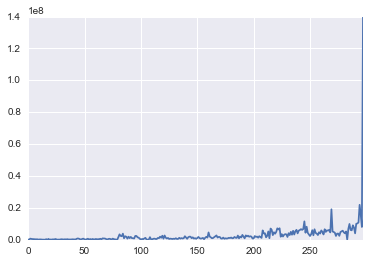

In [245]:
train_2007.Number_SKU_Sold.plot();

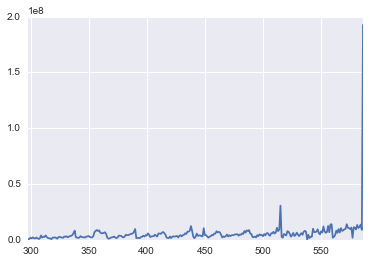

In [246]:
train_2008.Number_SKU_Sold.plot();

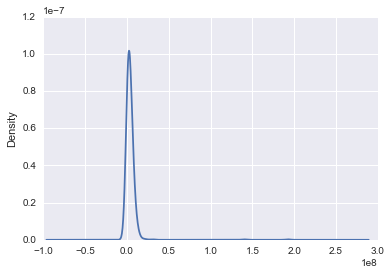

In [247]:
train.Number_SKU_Sold.plot(kind='kde');

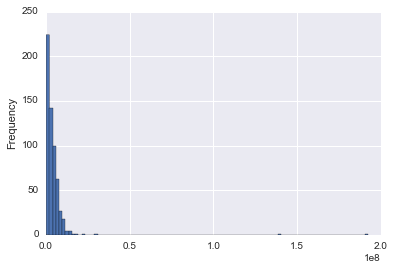

In [248]:
train.Number_SKU_Sold.plot(kind='hist', bins=100);

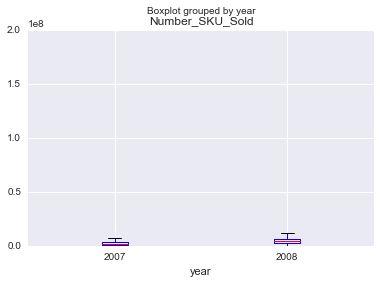

In [249]:
train.boxplot(column='Number_SKU_Sold', by='year');

In [250]:
train_2007.Number_SKU_Sold.describe()

count    2.980000e+02
mean     2.789848e+06
std      8.446760e+06
min      3.176200e+04
25%      5.111570e+05
50%      1.233304e+06
75%      3.394915e+06
max      1.396296e+08
Name: Number_SKU_Sold, dtype: float64

In [251]:
train_2008.Number_SKU_Sold.describe()

count    2.890000e+02
mean     5.487739e+06
std      1.150556e+07
min      4.932000e+04
25%      2.555650e+06
50%      4.127141e+06
75%      6.427382e+06
max      1.925327e+08
Name: Number_SKU_Sold, dtype: float64

In [32]:
train[train.Number_SKU_Sold > train.Number_SKU_Sold.quantile(q=0.99)]

,Date,Number_SKU_Sold,year,month,day
269,2007-11-24,19138073,2007,11,5
294,2007-12-22,21956074,2007,12,5
295,2007-12-23,15766750,2007,12,6
297,2007-12-25,139629635,2007,12,1
515,2008-09-25,30579435,2008,9,3
586,2008-12-24,192532706,2008,12,2


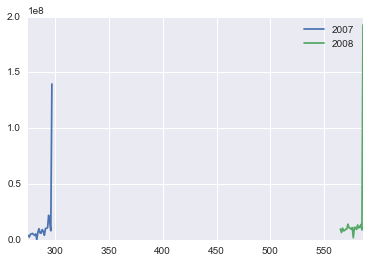

In [139]:
train_2007[train_2007.month==12].Number_SKU_Sold.plot(label='2007')
train_2008[train_2008.month==12].Number_SKU_Sold.plot(label='2008')
plt.legend(loc='best');

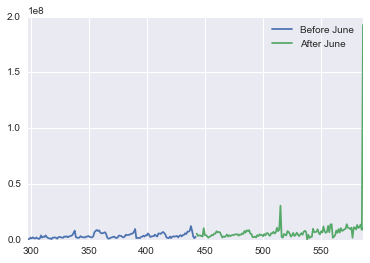

In [134]:
train_2008[train_2008.month <= 6].Number_SKU_Sold.plot(label='Before June')
train_2008[train_2008.month > 6].Number_SKU_Sold.plot(label='After June')
plt.legend(loc='best');

In [363]:
def do_cv(df, months, ests, features, transformation=False):
#     mask_train = (df.year == 2007) & (df.month == 2008) & (df.month.isin(months))
    
    mask_train = (df.Date < '2008-05-31') & (df.month.isin(months)) 
    X_train = df[mask_train][features]
    
    if transformation:
        y_train = df[mask_train].Number_SKU_Sold.map(np.log1p)
    else:
        y_train = df[mask_train].Number_SKU_Sold

    
    months = []
    scores = {}
    predictions = []
    
    for i in range(6, 12):
        months.append(i+1)
        mask = (df.year == 2008) & (df.month.isin(months))
        
        X_test = df[mask][features]
        
        if transformation:
            y_test = df[mask].Number_SKU_Sold.map(np.log1p)
        else:
            y_test = df[mask].Number_SKU_Sold.map(np.log1p)
        
        est_preds = []
        for est in ests:
            est.fit(X_train, y_train)
            preds = est.predict(X_test)
        
            if transformation:
                preds = np.expm1(preds)
            
            est_preds.append(preds)
        
        est_preds = np.array(est_preds)
        predictions.append(est_preds.mean(axis=0))
        
        scores[' '.join([str(month) for month in months])] = np.sqrt(mean_squared_error(y_test, est_preds.mean(axis=0)))
    
    return scores, predictions

In [387]:
features = ['day', 'quarter', 'month', 'is_sunday', 'is_saturday']

In [388]:
seeds = [44, 78, 192, 222]
estimators = [XGBRegressor(n_estimators=1000, learning_rate=0.01, seed=seed) for seed in seeds]

In [389]:
scores, predictions = do_cv(train, [1, 2, 3, 4, 5], estimators, features, transformation=True)

In [390]:
scores

{'7': 1502766.8262662026,
 '7 8': 1683257.3645920097,
 '7 8 9': 1624159.2901332604,
 '7 8 9 10': 1693581.3560108689,
 '7 8 9 10 11': 1731659.8643094914,
 '7 8 9 10 11 12': 1823772.3743465426}

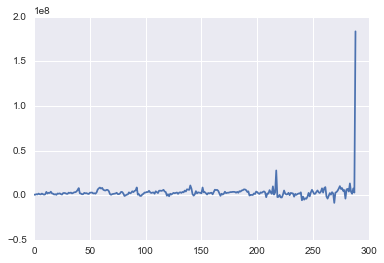

In [380]:
plt.plot(train_2008.iloc[:289].Number_SKU_Sold.values - train_2007.iloc[:289].Number_SKU_Sold.values);

ValueError: x and y must have same first dimension

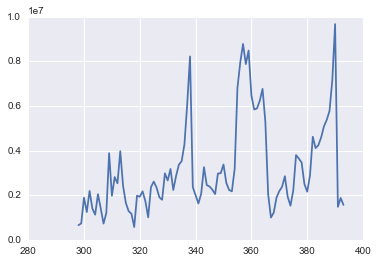

In [381]:
mask = (train.year == 2008) & (train.month.isin([1,2,3,4]))

plt.plot(train[mask].index, train[mask].Number_SKU_Sold, label='True')
plt.plot(train[mask].index, predictions[3], label='Predicted')
plt.legend(loc='best');

In [392]:
mask = (train.year == 2008) & (train.month.isin(np.arange(8, 12)))
X = train[mask][features]
y = train[mask].Number_SKU_Sold.map(np.log1p)

In [393]:
est = XGBRegressor(n_estimators=1000, learning_rate=0.01)
est.fit(X, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [394]:
final_preds = []
for est in estimators:
    final_preds.append(np.expm1(est.predict(test[features])))

In [395]:
final_preds = np.array(final_preds)

In [396]:
preds = final_preds.mean(axis=0)

In [397]:
sub['Number_SKU_Sold'] = preds

In [398]:
sub.to_csv('../submissions/last_4_transformed_xgbr_features_ensemble_remove_year.csv', index=False)